## 난임 환자 대상 임신 성공 여부 예측

### LGAimers 6th 온라인 해커톤

Import

In [9]:
import pandas as pd
import lightgbm as lgb
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier

### Data Load

In [10]:
# 데이터 로드
IVF_train = pd.read_csv('../data/IVF_train_dataset_19.csv')
IVF_test = pd.read_csv('../data/IVF_test_dataset_19.csv')

DI_train = pd.read_csv('../data/DI_train_dataset_19.csv')
DI_test = pd.read_csv('../data/DI_test_dataset_19.csv')

In [11]:
# ID 열을 제외한 특성과 타겟 변수 분리
IVF_X = IVF_train.drop(['임신_성공_여부', 'ID'], axis=1)
IVF_y = IVF_train['임신_성공_여부']

DI_X = DI_train.drop(['임신_성공_여부', 'ID'], axis=1)
DI_y = DI_train['임신_성공_여부']

### 인코딩 

In [12]:
IVF_categorical_columns = [
    "시술_시기_코드",
    "시술_당시_나이",
    "배란_유도_유형",
    "난자_출처",
    "정자_출처",
    "난자_기증자_나이",
    "정자_기증자_나이",
    "변환된_특정_시술_유형"
]

In [13]:
DI_categorical_columns = [
    "시술_시기_코드",
    "시술_당시_나이",
    "정자_기증자_나이",
    "변환된_특정_시술_유형"
]

In [14]:
# 모든 범주형 변수를 문자열로 변환
IVF_X[IVF_categorical_columns] = IVF_X[IVF_categorical_columns].astype(str)
DI_X[DI_categorical_columns] = DI_X[DI_categorical_columns].astype(str)
IVF_test[IVF_categorical_columns] = IVF_test[IVF_categorical_columns].astype(str)
DI_test[DI_categorical_columns] = DI_test[DI_categorical_columns].astype(str)

# OrdinalEncoder를 사용하여 범주형 변수 인코딩
IVF_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
DI_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

IVF_X[IVF_categorical_columns] = IVF_encoder.fit_transform(IVF_X[IVF_categorical_columns])
DI_X[DI_categorical_columns] = DI_encoder.fit_transform(DI_X[DI_categorical_columns])
IVF_test[IVF_categorical_columns] = IVF_encoder.transform(IVF_test[IVF_categorical_columns])
DI_test[DI_categorical_columns] = DI_encoder.transform(DI_test[DI_categorical_columns])

## Modeling

In [15]:
# 데이터 분할
IVF_X_train, IVF_X_test, IVF_y_train, IVF_y_test = train_test_split(IVF_X, IVF_y, test_size=0.2, random_state=42)
DI_X_train, DI_X_test, DI_y_train, DI_y_test = train_test_split(DI_X, DI_y, test_size=0.2, random_state=42)

### DI 데이터

[I 2025-02-05 01:47:24,736] A new study created in memory with name: no-name-8c167ef7-870f-4fc8-99cd-de0a31bb5d7a
[I 2025-02-05 01:47:33,834] Trial 0 finished with value: 0.6996177370030581 and parameters: {'n_estimators': 4558, 'num_leaves': 29, 'max_depth': 176, 'learning_rate': 0.00020484065293818876, 'min_child_samples': 236, 'subsample': 0.6487964370964557, 'colsample_bytree': 0.7780190643150715, 'reg_alpha': 8.682625101261633e-05, 'reg_lambda': 6.176323144156065, 'min_split_gain': 0.00014751662745589485}. Best is trial 0 with value: 0.6996177370030581.
[I 2025-02-05 01:47:42,469] Trial 1 finished with value: 0.6878331148973351 and parameters: {'n_estimators': 2982, 'num_leaves': 3019, 'max_depth': 88, 'learning_rate': 0.00018924463439409417, 'min_child_samples': 108, 'subsample': 0.812343051065807, 'colsample_bytree': 0.31505195722598556, 'reg_alpha': 0.7481701483235459, 'reg_lambda': 0.017634413770787494, 'min_split_gain': 0.011575919343618759}. Best is trial 0 with value: 0.699

Best trial:
  Value: 0.7136631716906945
  Params: 
    n_estimators: 1816
    num_leaves: 3926
    max_depth: 259
    learning_rate: 0.00238377640011148
    min_child_samples: 1
    subsample: 0.7610056627240331
    colsample_bytree: 0.6655579164853634
    reg_alpha: 0.00025227758337188327
    reg_lambda: 76.74410721512268
    min_split_gain: 0.007773520329665474

--- Model Performance ---
Model Accuracy: 0.8664546899841018
Model F1 Score: 0.0
Model AUC: 0.7012833114897334


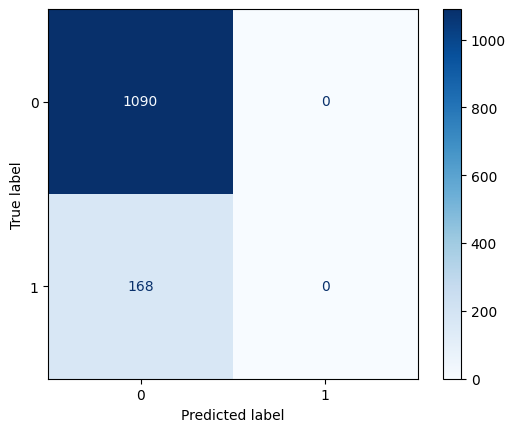

In [16]:
import optuna
import lightgbm as lgb
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# 타겟 변수 비율 계산
positive_samples = DI_y_train[DI_y_train == 1].shape[0]
negative_samples = DI_y_train[DI_y_train == 0].shape[0]
scale_pos_weight = negative_samples / positive_samples

# 목적 함수 정의
def objective(trial):
    param = {
        'objective': 'binary',
        'metric': 'auc',
        'verbose': -1,
        'boosting_type': 'gbdt',
        'n_estimators': trial.suggest_int('n_estimators', 100, 5000),
        'num_leaves': trial.suggest_int('num_leaves', 10, 4096),
        'max_depth': trial.suggest_int('max_depth', 3, 300),
        'learning_rate': trial.suggest_float('learning_rate', 1e-6, 1.0, log=True),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 300),
        'subsample': trial.suggest_float('subsample', 0.1, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-6, 1e3, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-6, 1e3, log=True),
        'min_split_gain': trial.suggest_float('min_split_gain', 1e-6, 1e2, log=True),
        'scale_pos_weight': scale_pos_weight,  # 클래스 불균형 처리
        'random_state': 42,
    }

    model = lgb.LGBMClassifier(**param)
    model.fit(DI_X_train, DI_y_train, eval_set=[(DI_X_test, DI_y_test)])
    
    y_pred_proba = model.predict_proba(DI_X_test)[:, 1]
    auc = roc_auc_score(DI_y_test, y_pred_proba)
    
    return auc

# Optuna 스터디 생성 및 최적화
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=1000)

# 최적의 하이퍼파라미터 출력
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

# 최적의 하이퍼파라미터로 모델 학습
best_params = trial.params
DI_model = lgb.LGBMClassifier(**best_params)
DI_model.fit(DI_X_train, DI_y_train)

# 예측
y_pred = DI_model.predict(DI_X_test)
y_pred_proba = DI_model.predict_proba(DI_X_test)[:, 1]

# 평가
accuracy = accuracy_score(DI_y_test, y_pred)
f1 = f1_score(DI_y_test, y_pred)
auc = roc_auc_score(DI_y_test, y_pred_proba)
cm = confusion_matrix(DI_y_test, y_pred)

# 결과 출력
print()
print("--- Model Performance ---")
print(f"Model Accuracy: {accuracy}")
print(f"Model F1 Score: {f1}")
print(f"Model AUC: {auc}")

# 혼동 행렬 출력
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=DI_model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()

.